# Digitally Reconstructed Radiograph (DDR) generation
---

This notebook demonstrates the creation of a DRR

## 1. Importing libraries

In [1]:
import sys
import random
import numpy as np
import torch
import torchio as tio

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders, add_vessel_contrast
# from src.config import config
from src.drr import create_drr
from src.vizualization import plot_results, plot_drr_enhancement

import torch
import matplotlib.pyplot as plt
from diffdrr.visualization import plot_drr, plot_mask

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.data import read, transform_hu_to_density

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

from tqdm import tqdm

from src.model import TACEnet
from monai.losses import DiceCELoss

from torchvision import transforms

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Data preprocessing
In this pipeline we make use of HCC-TACE-Seg dataset. This retrospectively acquired data collection includes pre- and post-procedure CT imaging studies of 105 confirmed HCC patients who underwent TACE between 2002 and 2012 with an available treatment outcome, in the form of time-to-progression and overall survival. Baseline imaging includes multiphasic contrast-enhanced CT with no image artifacts (e.g. surgical clip) and was obtained 1-12 weeks (average 3 weeks) prior to the first TACE session. Semiautomatic segmentation of liver, tumor, and blood vessels created using AMIRA was manually clinically curated. These segmentations of each pre-procedural CT study were done for the purpose of algorithm training for prediction and automatic liver tumor segmentation, and are provided here (NIfTI converted to DICOM-SEG format).


The volumes and segmnetations have the following shapes when loaded from a batch:

- volume: (1, 1, 512, 512, D) -> (B, C, H, W, D) where the depth (D) is not constant
- segmentation (1, 5, 512, 512, D) -> (B, C, H, W, D) where the depth (D) is not constant and correpsonds to volume


The following tranformations are then performed:
1. Load volume and segmentation to MONAI meta tensor.
2. Ensure the channel dimension is placed before the spatial dimensions
3. Resize the volume and segmnetation to a new desired dimension, using padding and cropping (optional).
4. Isolate the vessel channel of the multi class segmentation mask. This essentially turns the task in a binary segmentation problem where the segmentation will have a shape equal to the volume: (1, 1, 512, 512, D).

In [2]:
# Get transforms
transform = get_transforms(resize_shape= [512, 512, 96], contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data081",
    collection="HCC-TACE-Seg",
    transform=transform,
    download=False,
    val_frac=0.0,
    download_len=1,
    seed=42
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets to make sure data split is correct
print(train_ds.get_indices(), val_ds.get_indices())

[0] []


In [3]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
volumes, targets = batch["image"], batch["seg"]

print(volumes.shape, targets.shape)

torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 1, 512, 512, 96])


From these volumes and segmentation we can take a slice and visualize the slice to evaulate the inputs

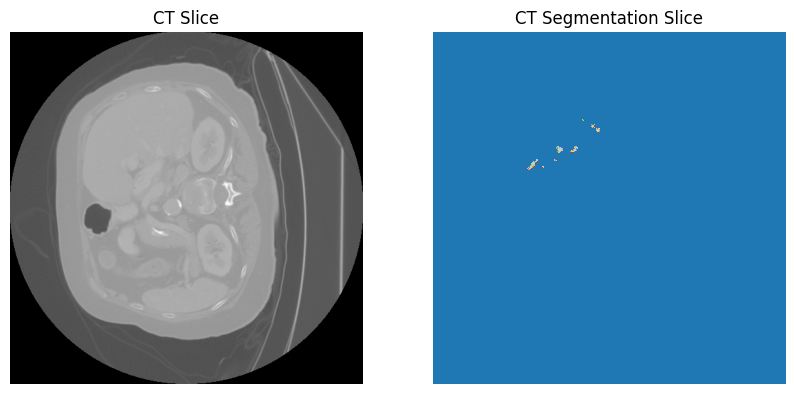

In [14]:
slice_idx = 40

# Sample a slice from the image
CT_slice = volumes[0, 0, :, :, slice_idx].cpu()

# Get the maximum segmentation class for each pixel in the slice
CT_seg_slice = targets[0, 0, :, :, slice_idx].cpu()

# Plot the image and segmentation slice as a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(CT_slice, cmap="gray")
ax[0].set_title("CT Slice")
ax[0].axis("off")
ax[1].imshow(CT_seg_slice, cmap="tab20")
ax[1].set_title("CT Segmentation Slice")
ax[1].axis("off")
plt.show()

## 3. Creating DRR Images
DRR images are essentially simulated X-ray images reconsturcted by raytracing through a given 3D CT volume. The DiffDRR package comes with most of the functionality needed out-of-the-box. We will demonstrate below how to create DRR images and control output rotation, zoom and more. Currently, this does not works vectorized over a batch. 

In [15]:
# Extract first image and segmentation from the batch
img = volumes[0]
seg = targets[0]

# Read in CT volume and label map into a subject object
subject = read(
    tensor=img,
    label_tensor=seg,
    orientation="AP",
    bone_attenuation_multiplier=5,
)

# Create a DRR object, this will project the CT to the DRR
drr = DRR(
    subject,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample=None,  # Proportion of pixels to randomly subsample
    reshape=True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis=True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size=None,  # Render patches of the DRR in series
    renderer="siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)

# Define the camera pose with rotations and translations in degrees, later converted to radians
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)

# Convert the rotations and translations to a pose matrix
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

# Generate the DRR
drr_image_raw = drr(pose, mask_to_channels=True)

In [16]:
# Enhance the vessel contrast in the CT using the segmentation
img_enhanced = add_vessel_contrast(img, seg, contrast_value=2000)

# Read in CT volume and label map into a subject object
subject_enhanced = read(
    tensor=img_enhanced,
    label_tensor=seg,
    orientation="AP",
    bone_attenuation_multiplier=5,
)

# Create a DRR object, this will project the CT to the DRR
drr_enhanced = DRR(
    subject_enhanced,  # A torchio.Subject object storing the CT volume, origin, and voxel spacing
    sdd=1020,  # Source-to-detector distance (i.e., the C-arm's focal length)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    width=200,  # Width of the DRR
    delx=2.0,  # Pixel spacing (in mm)
    dely=2.0,  # Pixel spacing (in mm)
    x0=0,  # # Principal point X-offset
    y0=0,  # Principal point Y-offset
    p_subsample=None,  # Proportion of pixels to randomly subsample
    reshape=True,  # Return DRR with shape (b, 1, h, w)
    reverse_x_axis=True,  # If True, obey radiologic convention (e.g., heart on right)
    patch_size=None,  # Render patches of the DRR in series
    renderer="siddon",  # Rendering backend, either "siddon" or "trilinear"
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
zero = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 800.0, 0.0]], device=device)

# Define the camera pose with rotations and translations in degrees, later converted to radians
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
rotations = torch.deg2rad(rotations)

# Convert the rotations and translations to a pose matrix
pose1 = convert(zero, translations, parameterization="euler_angles", convention="ZXY")
pose2 = convert(rotations, zero, parameterization="euler_angles", convention="ZXY")
pose = pose1.compose(pose2)

# Generate the DRR
drr_image_enhanced = drr_enhanced(pose, mask_to_channels=True)

The implementation of the DRR generation allows us to visualize both the entire image and only certain structures of interest, in this case the vessels. We can now visualize the raw DRR, the vessels only and the enhanced DRR. Note that the output of the DRR has the following shape:

$$(B, C, H, W) -> (1, 2, 200, 200)$$

Where the B does not correspond to the dataloaders batch, but the number of different poses that are provided. This means that, although DRR image generation currently only works with 1 volume segmentation pair at once, per volume multiple DRR orientations can be created in parallel. Since we are interested in changing the angle this makes it perfectly sufficient to only uses batches of size 1 and create multiple DRR images for training per batch iteration.

C is the number of channels per generated DRR (this by setting `mask_to_channel = True`) and allows for conditional rendering of different structures. Summing over the channel dimension will give the expected image. Note that the `plot_drr` function takes in a shape of (B, C, H, W), which explains the added logic below.

[<Axes: xlabel='Vessel Overlay'>]

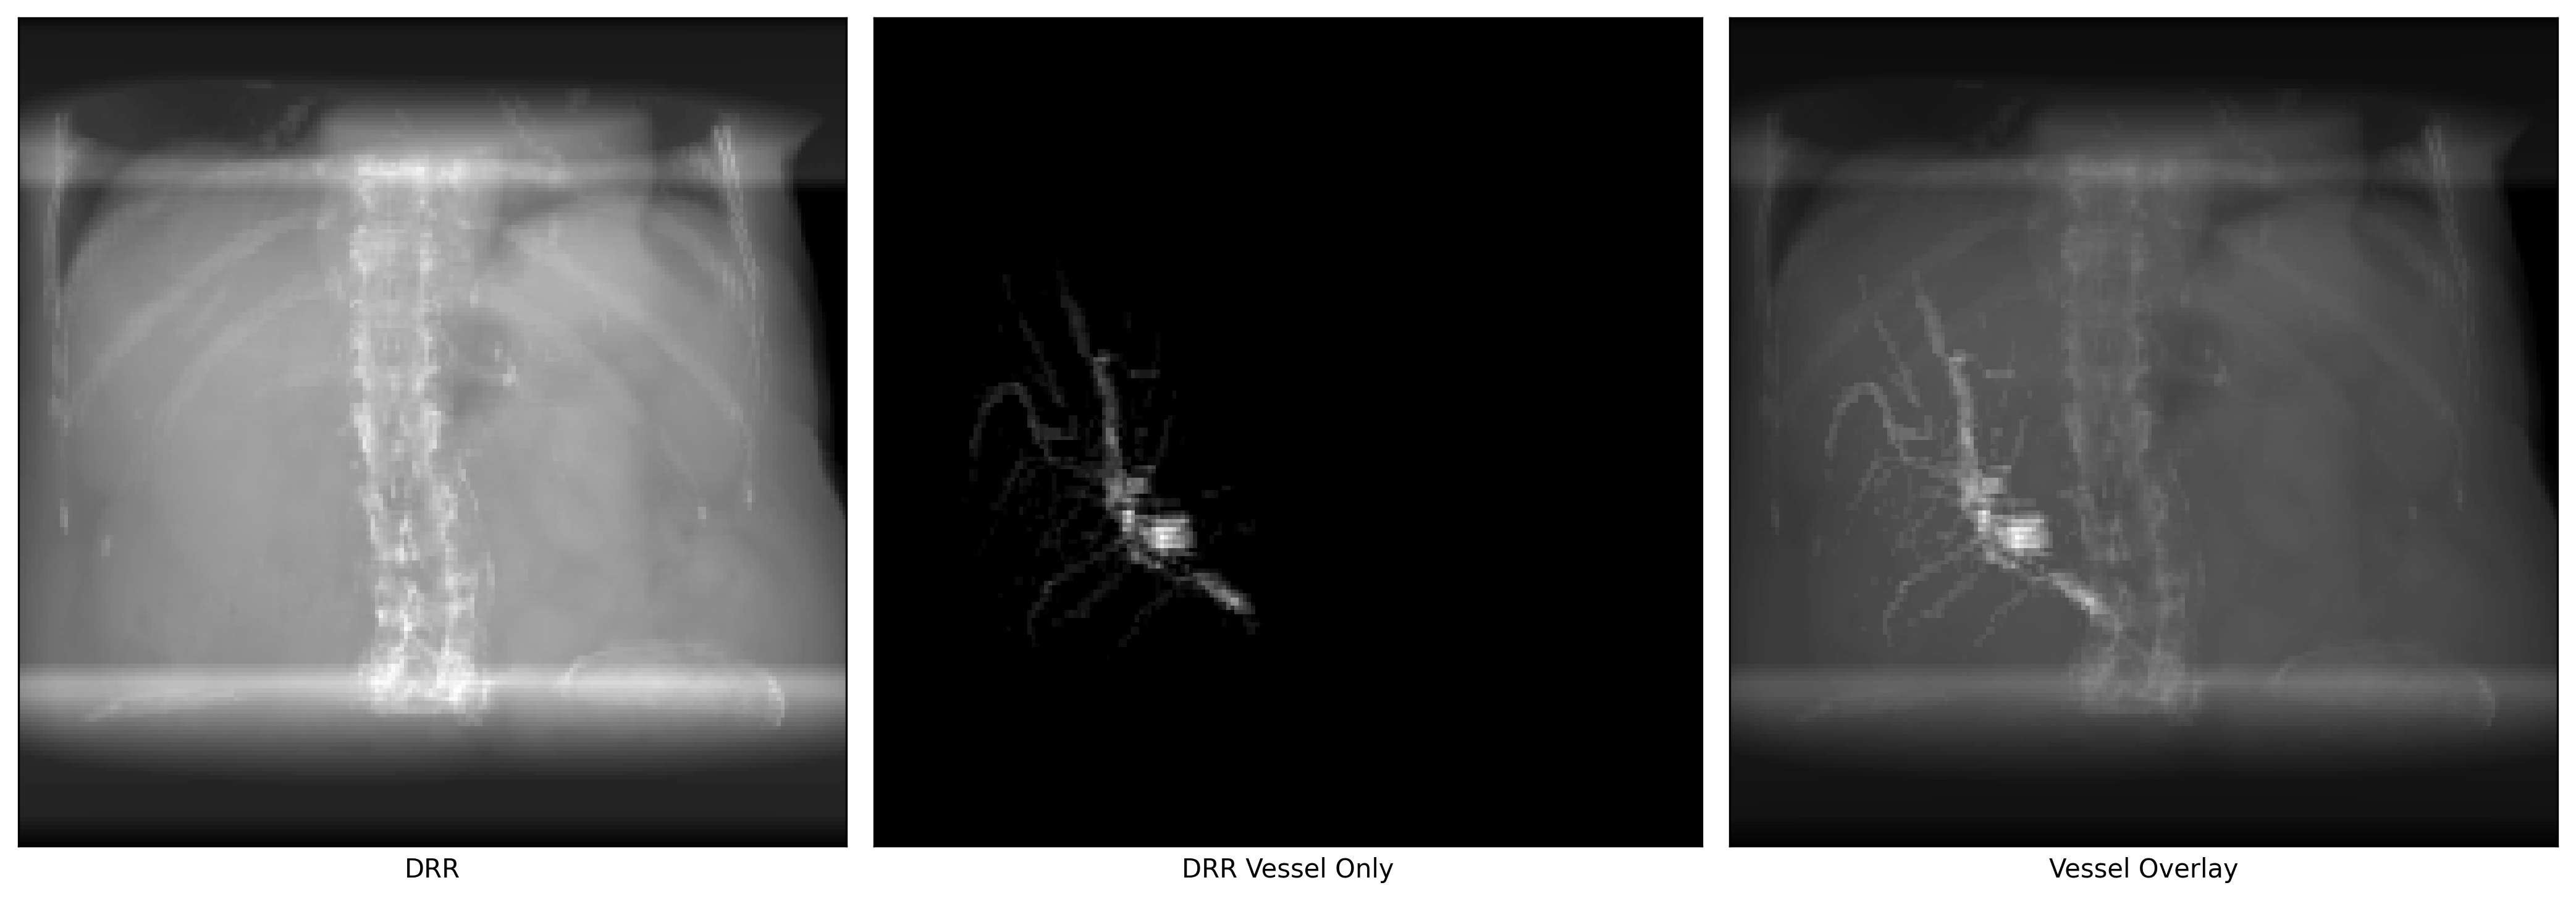

In [17]:
# Plot the segmentation masks
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(14, 7.75),
    tight_layout=True,
    dpi=300,
)

# Plot the DRR, DRR with vessel contrast, and the enhanced DRR
plot_drr(drr_image_raw.sum(dim=1, keepdim=True), axs=axs[0], ticks=False, title="DRR")
plot_drr(
    drr_image_enhanced[:, 1, :, :].unsqueeze(dim=1),
    axs=axs[1],
    ticks=False,
    title="DRR Vessel Only",
)
plot_drr(
    drr_image_enhanced.sum(dim=1, keepdim=True),
    axs=axs[2],
    ticks=False,
    title="Vessel Overlay",
)